# Application of unsupervised learning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## I/ Découverte du dataset
Pour cet exercice d'algorithmes non supervisé nous allons travailler sur le dataset de **Sci-Kit Learn** `fetch_lfw_people` (**Labeled Faces in the Wild**) dont la documentation est disponible sur les liens suivants:
- [Documentation de Sci-Kit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)
- [Site de Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)

**"Labeled Faces in the Wild"** est un dataset regroupant un ensemble de photos de célébrités labellisées, qui sont collectées spécialement pour l'étude du problème de la reconnaissance faciale

In [3]:
people = fetch_lfw_people(min_faces_per_person=30, resize=0.7)
print("Contenu du Dataset")
for key in people.keys():
    print(f"- {key :20} ")

Contenu du Dataset
- data                 
- images               
- target               
- target_names         
- DESCR                


In [4]:
print(people.DESCR)

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

Le jeu de données utilisé dans cet exemple est appelé "Labeled Faces in the Wild" (LFW). Il comprend des images de visages de personnes célèbre

Il serait intéressant de faire du clustering sur des visages pour plusieurs raisons :
- Identifier automatiquement des groupes ou des sous-groupes de visages similaires.
- Révéler des structures et des similitudes intéressantes parmi les visages, en regroupant les visages qui partagent des caractéristiques communes
- Explorer et visualiser les données


## II/ Analyse et prétraitements des données

In [5]:
print(f"Le dataset comporte {people.data.shape[0]} visages.")

Le dataset comporte 2370 visages.


Affichage des données

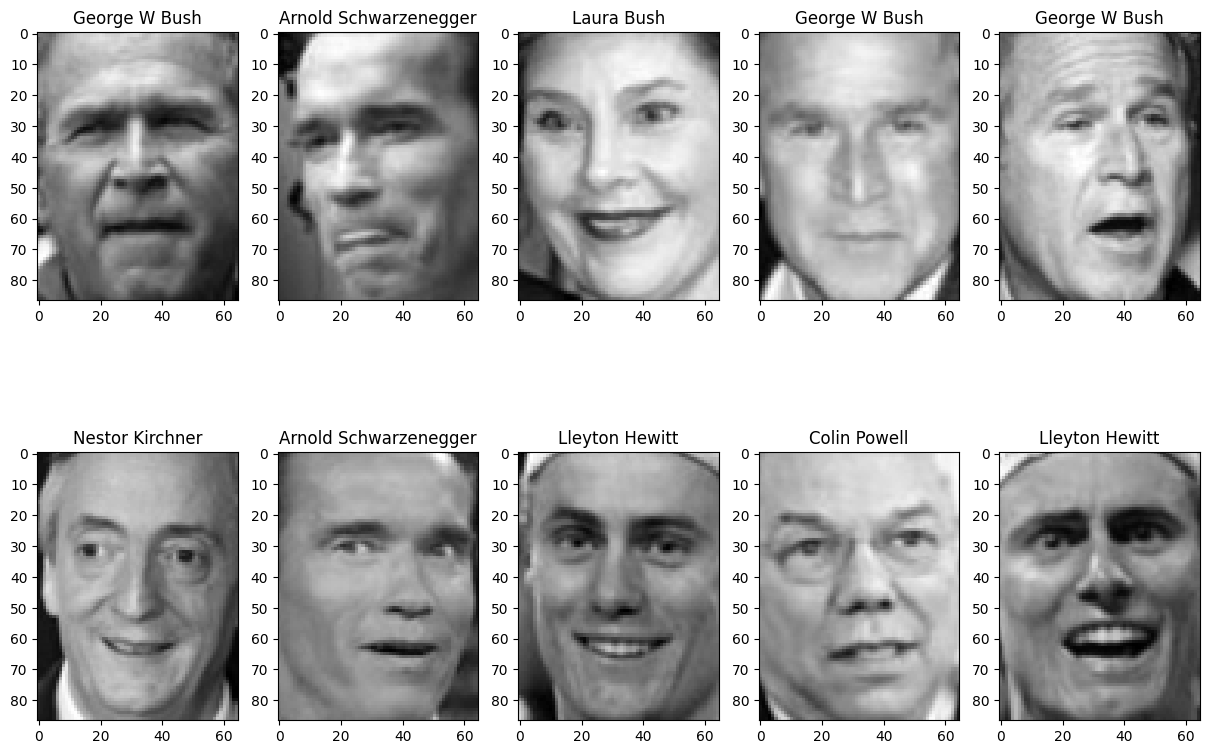

In [59]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap=plt.cm.gray)
    ax.set_title(people.target_names[target])

In [7]:
def histo(people, target):
    counts = np.bincount(target)
    # print counts next to target names:
    for i, (count, name) in enumerate(zip(counts, people.target_names)):
        print("{0:25}\t{1:3}".format(name, count), end="\t\t")
        if (i + 1) % 2 == 0:
            print()


histo(people, people.target)

Alejandro Toledo         	 39		Alvaro Uribe             	 35		
Andre Agassi             	 36		Ariel Sharon             	 77		
Arnold Schwarzenegger    	 42		Colin Powell             	236		
David Beckham            	 31		Donald Rumsfeld          	121		
George W Bush            	530		Gerhard Schroeder        	109		
Gloria Macapagal Arroyo  	 44		Guillermo Coria          	 30		
Hans Blix                	 39		Hugo Chavez              	 71		
Jacques Chirac           	 52		Jean Chretien            	 55		
Jennifer Capriati        	 42		John Ashcroft            	 53		
John Negroponte          	 31		Junichiro Koizumi        	 60		
Kofi Annan               	 32		Laura Bush               	 41		
Lleyton Hewitt           	 41		Luiz Inacio Lula da Silva	 48		
Megawati Sukarnoputri    	 33		Nestor Kirchner          	 37		
Recep Tayyip Erdogan     	 30		Roh Moo-hyun             	 32		
Serena Williams          	 52		Silvio Berlusconi        	 33		
Tom Ridge                	 33		Tony Blair              

##### Egalisation des données

Certaines personnalités sont surprésentés dans le jeu de données. Pour éviter que nos algorithmes ne soient biaisés par ces personnalités, nous allons réduire les données de façon à ce qu'elles soietn égales.

In [8]:
median_count = np.median(np.bincount(people.target))
median_count

41.5

In [9]:
select = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    select[np.where(people.target == target)[0][: int(median_count)]] = 1

X_people = people.data[select]
y_people = people.target[select]
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people)
print(f"{X_train.shape = } ")
print(f"{y_train.shape = } ")
print(f"{X_test.shape = } ")
print(f"{y_test.shape = } ")

X_train.shape = (961, 5655) 
y_train.shape = (961,) 
X_test.shape = (321, 5655) 
y_test.shape = (321,) 


In [10]:
histo(people, y_people)

Alejandro Toledo         	 39		Alvaro Uribe             	 35		
Andre Agassi             	 36		Ariel Sharon             	 41		
Arnold Schwarzenegger    	 41		Colin Powell             	 41		
David Beckham            	 31		Donald Rumsfeld          	 41		
George W Bush            	 41		Gerhard Schroeder        	 41		
Gloria Macapagal Arroyo  	 41		Guillermo Coria          	 30		
Hans Blix                	 39		Hugo Chavez              	 41		
Jacques Chirac           	 41		Jean Chretien            	 41		
Jennifer Capriati        	 41		John Ashcroft            	 41		
John Negroponte          	 31		Junichiro Koizumi        	 41		
Kofi Annan               	 32		Laura Bush               	 41		
Lleyton Hewitt           	 41		Luiz Inacio Lula da Silva	 41		
Megawati Sukarnoputri    	 33		Nestor Kirchner          	 37		
Recep Tayyip Erdogan     	 30		Roh Moo-hyun             	 32		
Serena Williams          	 41		Silvio Berlusconi        	 33		
Tom Ridge                	 33		Tony Blair              

##### PCA pour une réduction de dimensions

Dans le but de faire une réduction de dimension nous allons appliquer la PCA sur le jeu de données d'entrainement `X_train`. La PCA peut faciliter le processus de clusterisation en réduisant le nombre de dimension. Cela peut aider à améliorer la précision et l'interprétation des clusters obtenus, en mettant en évidence les différences et les similitudes les plus importantes entre les points de données.

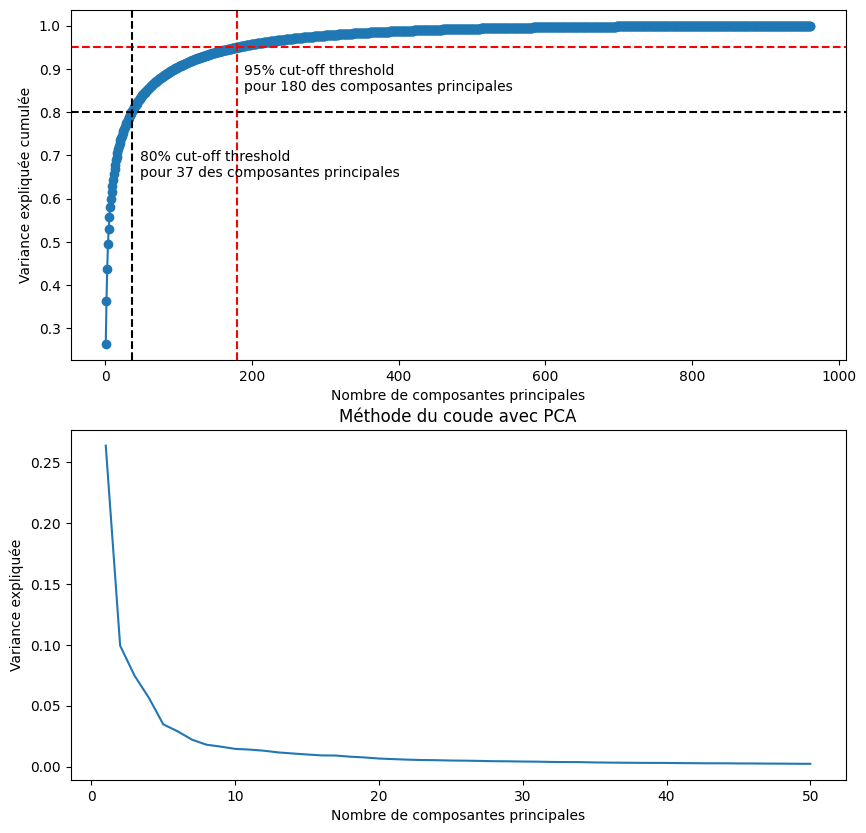

In [295]:
from sklearn.metrics.cluster import v_measure_score

pca = PCA()
pca.fit(X_train)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

variance_threshold = 0.95
n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
n_components_2 = np.argmax(cumulative_variance >= 0.80) + 1

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker="o")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.axhline(y=variance_threshold, color="r", linestyle="--")
plt.axvline(x=n_components, color="r", linestyle="--")
plt.text(
    n_components + 10,
    0.85,
    f"95% cut-off threshold \npour {n_components} des composantes principales",
    color="black",
)

plt.axhline(y=0.80, color="black", linestyle="--")
plt.axvline(x=n_components_2, color="black", linestyle="--")
plt.text(
    n_components_2 + 10,
    0.65,
    f"80% cut-off threshold \npour {n_components_2} des composantes principales",
    color="black",
)

plt.subplot(2, 1, 2)
plt.plot(range(1, len(explained_variance) + 1)[:50], explained_variance[:50])
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée")
plt.title("Méthode du coude avec PCA")

plt.show()
plt.show()

Ici, un nombre de composantes de 180 est choisi pour la PCA car elles perttent de conserver 95% de la variances des données. On peut aussi faire une PCA plus restrictive en choisissant un nombre de composantes plus faible, mais cela peut avoir un impact sur la précision des clusters obtenus.

In [263]:
pca = PCA(n_components=n_components, random_state=0).fit(X_train)


X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target)[:]:
    mask[np.where(people.target == target)[0][:50]] = True
mask

array([ True,  True,  True, ..., False,  True, False])

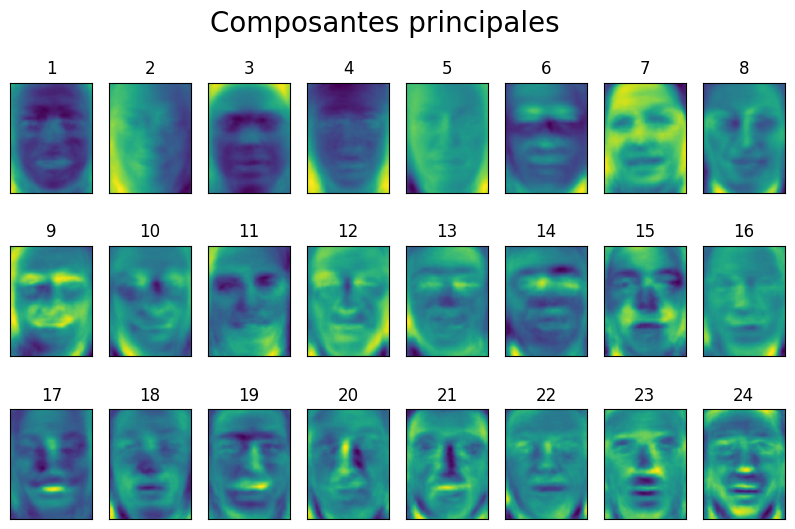

In [271]:
fig, axes = plt.subplots(3, 8, figsize=(10, 6), subplot_kw={"xticks": (), "yticks": ()})
fig.suptitle("Composantes principales", fontsize=20)
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(people.images[0].shape), cmap="viridis")
    ax.set_title(f"{i+1}")

## III/ Application des Algos de Clustering

### A) KMeans

On va essayer de jouer sur le nombre de clusters pour voir si on peut obtenir des résultats intéressants. On va augmenter le nombre de clusters progressivement pour voir quelles carractéristiques sont mises en avant par l'algorithme quand il y a un petit nombre de clusters et quand il y en a un grand nombre.

In [307]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

nbr_people = len(people.target_names)


def build_kmeans(nbr_cluster):
    kmeans = KMeans(n_clusters=nbr_cluster, random_state=0)
    kmeans.fit(X_train_pca)
    return kmeans


kmeans_5 = build_kmeans(5)
kmeans_50 = build_kmeans(50)
kmeans_100 = build_kmeans(100)

C:\Users\chars\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chars\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chars\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


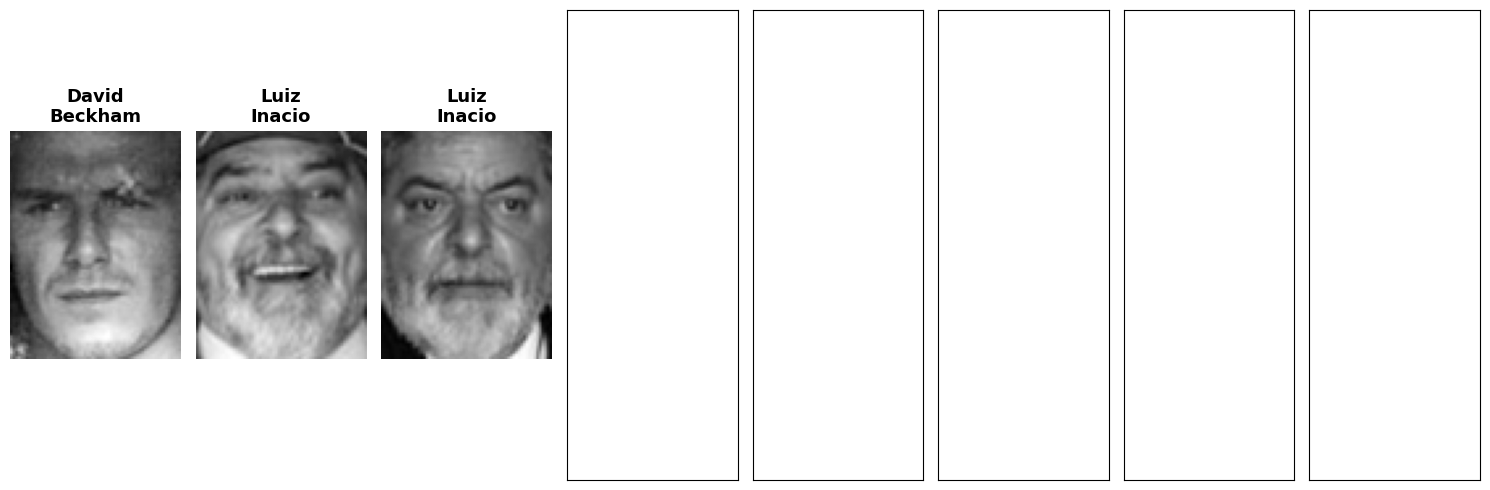

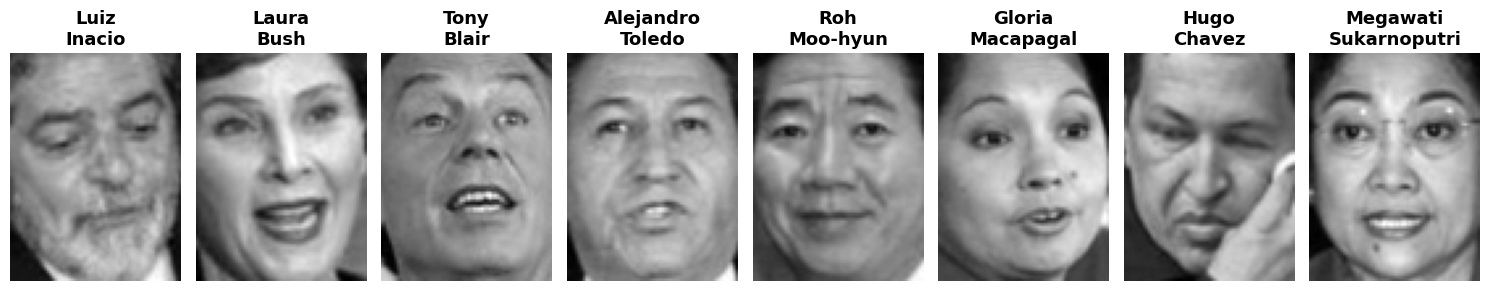

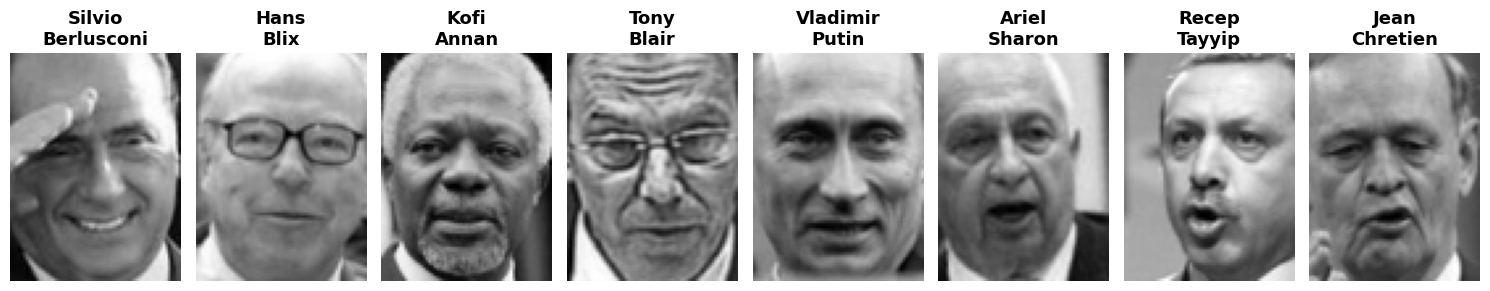

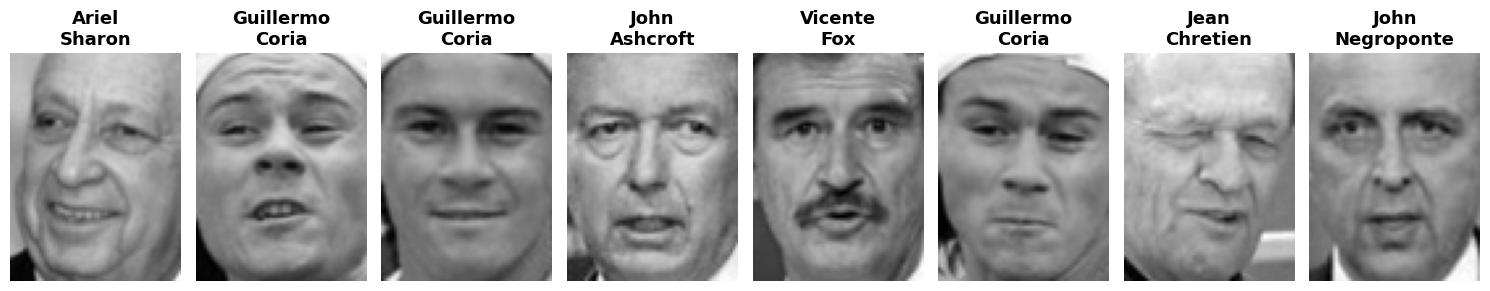

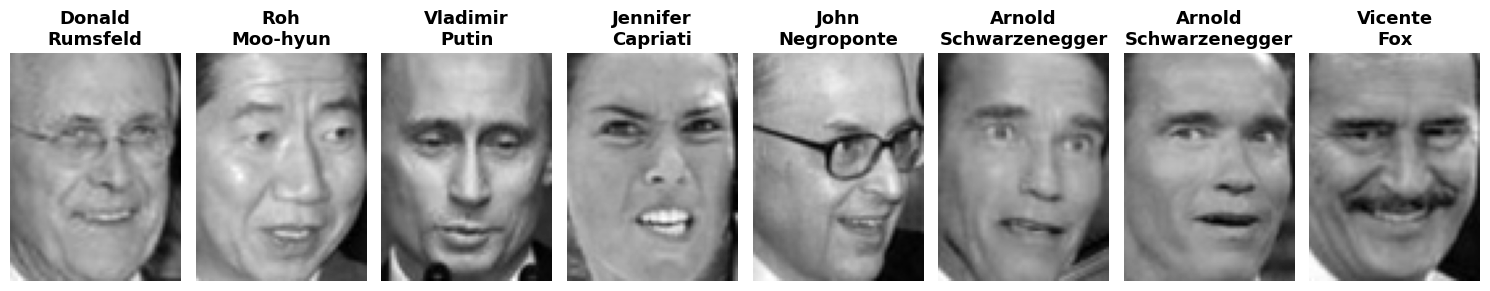

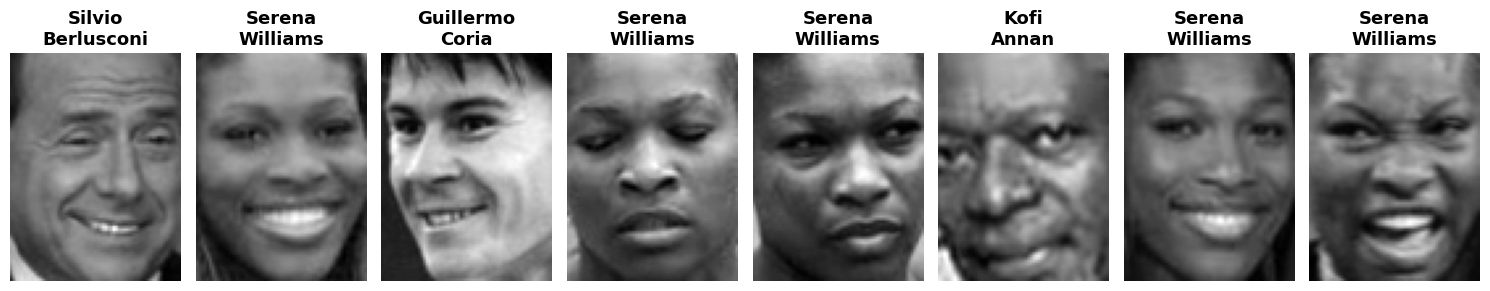

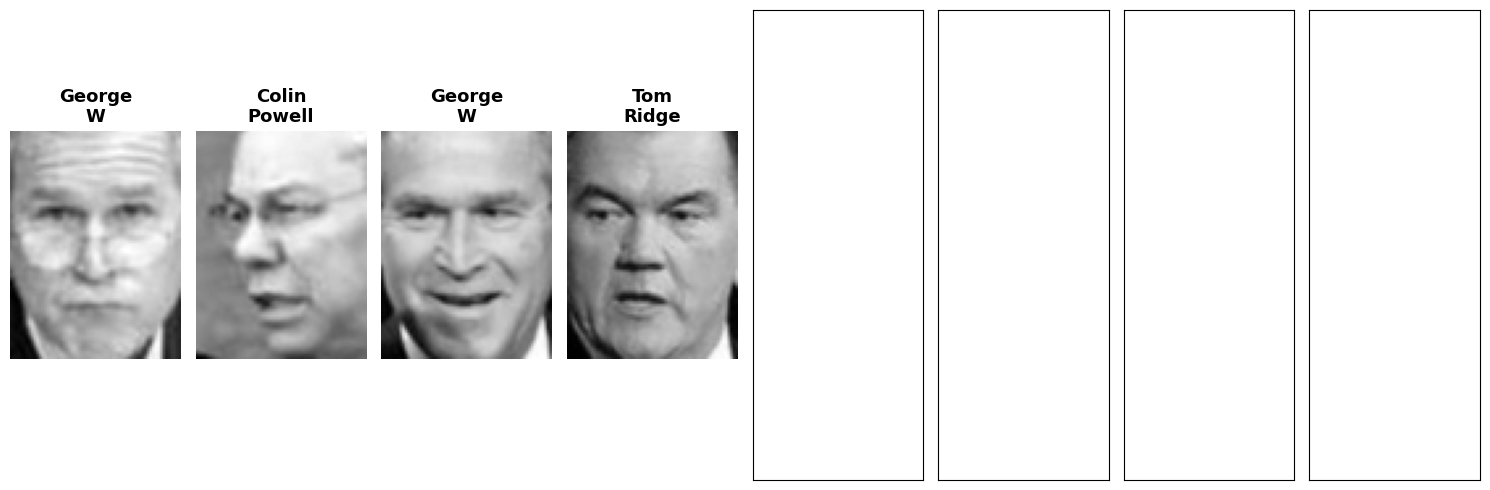

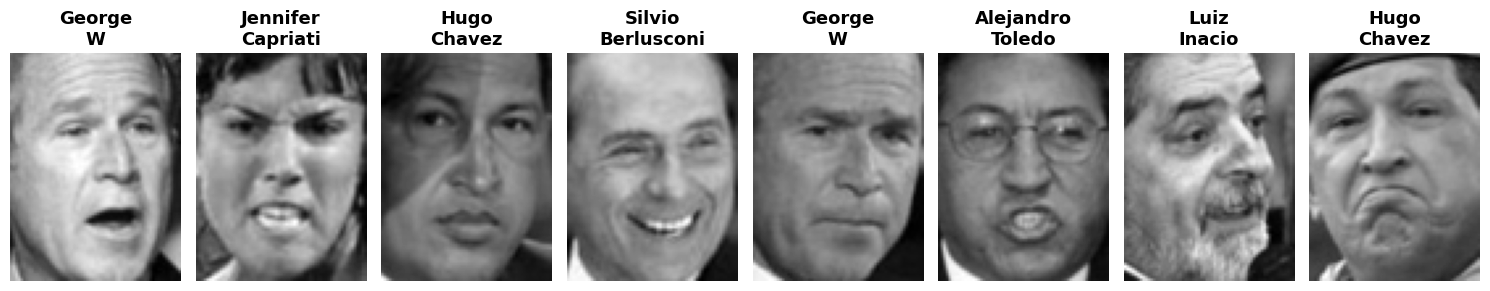

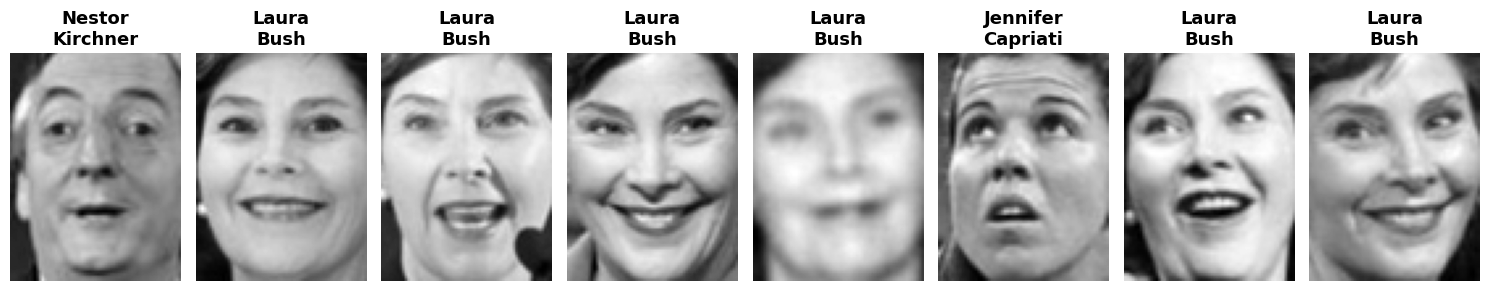

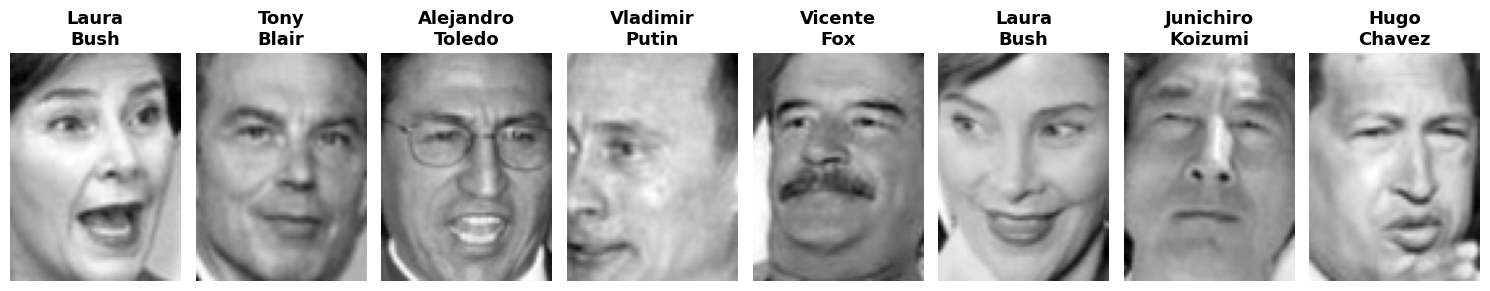

In [315]:
def show_people_by_cluster(cluster, algo):
    closest_indices, _ = pairwise_distances_argmin_min(
        algo.cluster_centers_, X_train_pca
    )
    fig, axes = plt.subplots(
        1, 8, figsize=(15, 5), subplot_kw={"xticks": (), "yticks": ()}
    )

    ## See in a same cluster what is the images
    same_cluster = np.where(algo.labels_ == cluster)[0]
    cluster_images = X_train[same_cluster]
    distance = pairwise_distances_argmin_min(
        X_train_pca[same_cluster], algo.cluster_centers_[cluster].reshape(1, -1)
    )
    sorted_index = np.argsort(distance[0])

    for i, idx in enumerate(sorted_index):
        img = cluster_images[idx]
        ax = axes.ravel()[i % 8]
        ax.imshow(img.reshape((87, 65)), cmap="gray")
        str = people.target_names[y_train[same_cluster[idx]]].split(" ")
        ax.set_title(
            f"{str[0]}\n{str[1]}", fontdict={"fontsize": 13, "fontweight": "bold"}
        )
        ax.axis("off")
    plt.tight_layout()
    


for i in range(0, 10):
    show_people_by_cluster(i, kmeans_100)
plt.show()

### B) DBSCAN

In [135]:
X_train.shape

(961, 5655)

In [299]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

pca_test = PCA(n_components=37)
X_pca = pca_test.fit_transform(X_train)
dbscan = DBSCAN(min_samples=3, eps=8)
labels_pred = dbscan.fit_predict(X_pca)
# labels_pred = dbscan.labels_
print(np.unique(labels_pred))
ari = adjusted_rand_score(y_train, labels_pred)
print(ari)

[-1  0  1  2  3]
0.0031010979940548173


In [303]:
show_people_by_cluster(0, algo=dbscan)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 37 while Y.shape[1] == 180

In [234]:
for eps in [6, 7, 8, 9, 10, 11, 12, 14]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_train_pca)
    ari = adjusted_rand_score(y_train, labels_pred)
    print(ari)


eps=6
0.0012532535789170718

eps=7
0.0012532535789170718

eps=8
0.0012532535789170718

eps=9
0.0012532535789170718

eps=10
0.0012532535789170718

eps=11
0.0012532535789170718

eps=12
0.0012532535789170718

eps=14
0.0012532535789170718


In [221]:
labels_pred

array([ 0,  0, -1,  0,  0, -1, -1, -1, -1, -1, -1,  0, -1,  0,  0,  0, -1,
       -1, -1,  0, -1,  0, -1,  0,  0, -1, -1, -1, -1, -1,  0, -1,  0, -1,
        0,  0, -1,  0, -1, -1, -1, -1, -1,  0, -1,  0,  0,  0, -1,  0, -1,
       -1, -1, -1,  0, -1, -1,  0, -1,  0, -1, -1, -1, -1, -1,  0, -1, -1,
       -1,  0, -1,  0,  0,  0, -1,  0, -1,  0,  0, -1, -1, -1, -1,  0, -1,
        0, -1, -1,  0, -1,  0,  0, -1,  0,  0, -1, -1, -1, -1,  0, -1,  0,
       -1,  0,  0, -1,  0,  0, -1, -1, -1,  0, -1,  0,  0, -1, -1, -1,  0,
       -1,  0,  0,  0, -1, -1, -1, -1, -1,  0,  0, -1,  0,  0,  0,  0, -1,
       -1, -1,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1,  0,  0, -1,  0, -1, -1, -1,  0, -1, -1,
        0, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,
        0, -1, -1, -1,  0, -1,  0,  0,  0, -1, -1,  0, -1, -1, -1, -1, -1,
       -1,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0, -1, -1, -1,  0, -1, -1,
       -1,  0,  0,  0, -1